In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Imports and read file to corpus

In [9]:
# Use this block to download necessary packets for nltk

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [65]:
import nltk
import gensim
import re
import pickle
from gensim import corpora
from gensim.parsing.preprocessing import *
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import pyLDAvis.gensim
import numpy as np
import os
from pprint import pprint
import pickle

# Figures
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd

# For MAC OS
mallet_path = 'mallet-2.0.8/bin/mallet'
os.environ['MALLET_HOME'] = 'mallet-2.0.8'

# For Windows OS
#os.environ['MALLET_HOME'] = 'C:\\mallet'
#mallet_path = 'C:\\mallet\\bin\\mallet.bat'

In [66]:
def readFile(folder, filename):
    fileData = ""
    file = open(folder + "/" + filename, 'r', encoding='utf8')
    fileData = file.read().splitlines()
    file.close
    return fileData

In [8]:
def createEmptyFile(filename):
    file = open("authors/" + filename, 'w').close()

In [9]:
def saveToFile(filename, abstract):
    if len(abstract) > 0:
        file = open("authors/" + filename, 'a')
        try:
            file.writelines(abstract + "\n")
        except:
            file.write("\n")
            print("\n Write exception")
        file.close
        print('+', end='')
        return True
    else:
        print('-', end='')
        return False

# TODO
* fix blankspace problem with authors in USENIX

In [67]:
corpus = []

# Used later to make diagrams
yearList = []
conferenceList = []
author = []

for i in range (2000,2021):
    conference = readFile('abstracts', 'usenix' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('Usenix')
        yearList.append(i)
    authors = readFile('authors', 'usenix' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)
        
for i in range (2000,2021):
    conference = readFile('abstracts', 'css' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('CSS')
        yearList.append(i)
    authors = readFile('authors', 'css' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)     

for i in range (2000,2021):   
    conference = readFile('abstracts', 'ieee' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('IEEE')
        yearList.append(i)
    authors = readFile('authors', 'ieee' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)

for i in range (2000,2021):
    conference = readFile('abstracts', 'ndss' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('NDSS')
        yearList.append(i)
    authors = readFile('authors', 'ndss' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)

# Save the years and conferences in a Panda table
df_year_conf = pd.DataFrame(np.column_stack((yearList, conferenceList)), columns=['Year', 'Conf'])
df_authors = pd.DataFrame(author, columns=['Authors'])

print('Number of abstracts:',len(corpus))
print('Number of authors:',len(author))

Number of abstracts: 5427
Number of authors: 5427


## Preprocessing of the corpus
Preprocess the raw corpues into a list of words for each document

In [78]:
df_authors

,Authors
0,"Jonathan Katz, Bruce Schneier"
1,"Michael Brown, Donny Cheung, Darrel Hankerson,..."
2,Matt Curtin
3,Robert Stone
4,"Yongguang Zhang, Bikramjit Singh"
...,...
5422,"Michael Schwarz , Moritz Lipp , Claudio Canell..."
5423,"Yang Zhang , Mathias Humbert , Bartlomiej Surm..."
5424,"Jairo Giraldo , Alvaro Cardenas , Murat Kantar..."
5425,"Tianhao Wang , Milan Lopuhaä-Zwakenberg , Zita..."


In [17]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            # lemmatized_sentence.append(word)
            pass# This part is modified so that we will just have ADJ VERB NOUN ADVERB remained 
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

Our list of stopwords

In [18]:
stop_words = ['achieve',
 'address',
 'analysis',
 'analyze',
 'apply',
 'approach',
 'base',
 'based',
 'build',
 'change',
 'compare',
 'component',
 'conduct',
 'construct',
 'control',
 'demonstrate',
 'design',
 'develop',
 'effort',
 'enable',
 'evaluate',
 'exist',
 'high',
 'identify',
 'implement',
 'implementation',
 'include',
 'introduce',
 'large',
 'level',
 'mechanism',
 'method',
 'multiple',
 'number',
 'obtain',
 'paper',
 'perform',
 'potential',
 'practice',
 'present',
 'previous',
 'prior',
 'problem',
 'process',
 'propose',
 'provide',
 'purpouse',
 'recent',
 'reduce',
 'report',
 'require',
 'result',
 'security',
 'service',
 'single',
 'solution',
 'specifically',
 'state',
 'study',
 'support',
 'technique',
 'time',
 'tool',
 'work']

def remove_ourStopwords(doc):
    return " ".join([word for word in doc.split() if word not in stop_words])

In [19]:
CUSTOM_FILTERS = [
    strip_tags,                            # Remove HTML tags and such
    strip_punctuation,                     # Remove punctuation
    strip_multiple_whitespaces,            # Remove unecessary space and such
    strip_numeric,                         # Remove numbers
    lambda x: strip_short(x, 4),           # Remove words shorter than 2 chars
    lambda y: y.replace('“', ''),          # Removes quation marks
    lambda z: z.replace('”', ''),          # Removes quation marks
    lambda a: a.lower(),                   # Makes the corpus lowercase
    lambda b: remove_stopwords(b),         # Removes stopwords 
    lambda c: remove_ourStopwords(c)       # Removes our stopwords
]

def clean_doc(doc):
    lematized_doc = lemmatize_sentence(doc)
    cleanDoc = preprocess_string(lematized_doc, CUSTOM_FILTERS)
    return cleanDoc

corpus_clean = [clean_doc(doc) for doc in corpus]


In [26]:
# Run if you want to see the full corpus
#corpus_clean

### Contiune the preprocessing, now with the list of words. Creating bigrams

In [20]:
bigram = gensim.models.Phrases(corpus_clean, min_count=5, threshold=50) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(corpus):
    return [bigram_mod[doc] for doc in corpus]

corpus_clean_bigram = make_bigrams(corpus_clean)

### Splitting the corpus and making it into a dictionary

In [21]:
dictionary = corpora.Dictionary(corpus_clean_bigram)
M1 = [dictionary.doc2bow(doc) for doc in corpus_clean_bigram]

print('Now we have', len(M1), 'unique words in M1')

Now we have 5427 unique words in M1


### Making the tfidf model
Not in use for LDA Mallet

In [18]:
tfidf_model = gensim.models.TfidfModel(M1)
tfidf_M1 = tfidf_model[M1]
#print(tfidf_model)
#print(tfidf_M1)
#print(M1)

## Save the model data to files
Used as backup and to find the optimal number of topics.

In [22]:
def saveModel(data, name):
    file = open("model/" + name, 'wb')
    pickle.dump(data, file)
    file.close
    print(name, 'saved.')

In [24]:
saveModel(dictionary, 'dictionaryData')
saveModel(M1, 'M1Data')
saveModel(corpus_clean_bigram, 'corpusData')

dictionaryData saved.
M1Data saved.
corpusData saved.


## Open the model data from files

In [14]:
def openDataFile(filename):
    file = open(filename,'rb')
    data = pickle.load(file)
    file.close()
    print(filename, 'read.')
    return data

In [16]:
dictionary = openDataFile('model/dictionaryData')
M1 = openFile('model/M1Data')
corpus_clean_bigram = openFile('model/corpusData')

model/dictionaryData read.
model/M1Data read.
model/corpusData read.


## Finding optimal number of topics
Use the findOptimalNumberOfTopics notebook to do the calculation
1. Save the dictionary, M1 and corpus to the /model folder (done by the previous code blocks)
3. Run the other notebook

## LDA mallet
Reads the LDA mallet model from the folder /mallet-2.0.8

In [176]:
# From the testing we have that the optimal number of topics is:
num_topics=14
random_seed=4

In [177]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=M1,
                                             num_topics=num_topics,
                                             id2word=dictionary,
                                            random_seed=random_seed)

In [178]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                           texts=corpus_clean_bigram,
                                           dictionary=dictionary, 
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('protocol', 0.05392809587217044),
   ('secure', 0.030958721704394142),
   ('computation', 0.025066577896138482),
   ('party', 0.023968042609853527),
   ('algorithm', 0.014980026631158456),
   ('efficient', 0.013781624500665779),
   ('compute', 0.012117177097203728),
   ('practical', 0.011717709720372836),
   ('setting', 0.010752330226364846),
   ('cost', 0.009953395472703063)]),
 (2,
  [('user', 0.05624959752720716),
   ('password', 0.028140897675317147),
   ('research', 0.017064846416382253),
   ('authentication', 0.013426492369115847),
   ('participant', 0.01252495331315603),
   ('human', 0.010593083907527851),
   ('suggest', 0.008693412325326808),
   ('experience', 0.008596818855045398),
   ('online', 0.007115718977397128),
   ('game', 0.006954729860261446)]),
 (1,
  [('memory', 0.0311577360386959),
   ('hardware', 0.024373390288334695),
   ('software', 0.02088699038884352),
   ('performance', 0.01887681387021798),
   ('kernel', 0.01859413279728626),
   ('protection', 0.01

## Visualisation of topics
First creating a lda mallet model and then visualising

In [179]:
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [180]:
lda_mallet_model = mallet_to_lda(ldamallet)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_mallet_model, M1, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3      0.042438 -0.134002       1        1  7.266675
9      0.175307 -0.056392       2        1  7.241895
10     0.101617 -0.032767       3        1  7.207994
8     -0.247869 -0.132180       4        1  7.195074
5     -0.255089 -0.009365       5        1  7.182888
2      0.169696 -0.149080       6        1  7.174801
12     0.034599 -0.092932       7        1  7.142438
4     -0.058853  0.250141       8        1  7.119108
6      0.179741  0.104417       9        1  7.112537
13     0.030005  0.117249      10        1  7.109631
1     -0.091899  0.262896      11        1  7.104920
7      0.115778 -0.045346      12        1  7.085407
0      0.034799  0.056889      13        1  7.078333
11    -0.230271 -0.139528      14        1  6.978299, topic_info=            Term         Freq        Total Category  logprob  loglift
2         attack  6770.000000  6770.000000  Default  30.0000  30.0000
256         data  4269.000000  4269.000000  Default  29.0000  29.0000
152      network  3042.000000  3042.000000  Default  28.0000  28.0000
86          user  4560.000000  4560.000000  Default  27.0000  27.0000
191  information  2312.000000  2312.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
413    adversary   235.549193   831.148632  Topic14  -4.8679   1.4015
199  performance   226.371951  1241.606996  Topic14  -4.9076   0.9604
641        input   201.899308  1005.278688  Topic14  -5.0220   1.0571
946    framework   177.426665  1064.706742  Topic14  -5.1512   0.8705
496        small   165.190343   558.006849  Topic14  -5.2227   1.4451

[1114 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
352      14  1.014504           abort
864      10  0.910790       abundance
1665      2  0.787511           abuse
1665     13  0.210363           abuse
172       3  0.000556          access
...     ...       ...             ...
816       6  0.102086            year
816      12  0.272229            year
4504      4  1.000061  zero_knowledge
4080      7  0.938119     ﬁngerprints
1191     14  0.980687           �good

[1663 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 11, 9, 6, 3, 13, 5, 7, 14, 2, 8, 1, 12])

# Panda

## Topic distribution over all documents

In [181]:
def topic_distribution(ldamodel, corpus, texts):
    topicPercent = []
    topicNumbers = []
    numberOfTopics = 0
    topicNames = []
    
    # Get all topics in each document
    for i, row in enumerate(ldamodel[corpus]):
        # Counts number of topics
        if i==0:
            numberOfTopics = len(row)
        topicPercent = []
        for topicNr, topicDistribution in row:
            topicPercent.append(topicDistribution)
        topicNumbers.append(topicPercent)

    dataframe = pd.DataFrame(topicNumbers)
    
    # Create names for each topic
    for i in range (0, numberOfTopics):
        topicName = 'Topic_' + str(i)
        topicNames.append(topicName)
        
    # Set all column lables
    dataframe.columns = topicNames
    
    return(dataframe)

topic_distribution_df = topic_distribution(ldamodel=ldamallet, corpus=M1, texts=corpus_clean_bigram)
topic_distribution_df


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13
0,0.111280,0.049814,0.053360,0.048632,0.043904,0.158561,0.040358,0.063999,0.088821,0.082911,0.052178,0.093549,0.047450,0.065181
1,0.075853,0.058154,0.106335,0.038489,0.047338,0.100435,0.070937,0.051271,0.092569,0.093552,0.054221,0.047338,0.049305,0.114201
2,0.061224,0.040467,0.096634,0.051456,0.079540,0.078319,0.051456,0.045351,0.081982,0.183325,0.063666,0.044130,0.055119,0.067329
3,0.071305,0.039187,0.033110,0.040055,0.093874,0.047867,0.053943,0.034846,0.033110,0.060888,0.336062,0.055680,0.058284,0.041791
4,0.030434,0.101141,0.039617,0.054309,0.046963,0.048800,0.078184,0.046045,0.046963,0.032271,0.272858,0.054309,0.057982,0.090122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,0.037109,0.568640,0.030602,0.020092,0.058630,0.038110,0.032604,0.036108,0.019091,0.021593,0.019091,0.022594,0.069641,0.026098
5423,0.092005,0.032334,0.030276,0.125612,0.055654,0.039193,0.027533,0.041936,0.024789,0.214776,0.037821,0.041250,0.196943,0.039879
5424,0.165977,0.031516,0.033126,0.183690,0.033126,0.025880,0.030711,0.068553,0.026685,0.070968,0.068553,0.042788,0.153094,0.065332
5425,0.105195,0.038528,0.053680,0.100144,0.046609,0.040548,0.048629,0.059740,0.048629,0.057720,0.043579,0.093074,0.208225,0.055700


## Topics per document
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.



In [575]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_num_string = 'Topic_' + str(int(topic_num))
                sent_topics_df = sent_topics_df.append(pd.Series([topic_num_string, round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Dominant_Topic_Per_Doc_Perc', 'Topic_Keywords']

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    #sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# df_topic_sents_keywords
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=M1, texts=corpus_clean_bigram)
df_topic_sents_keywords

,Dominant_Topic,Dominant_Topic_Per_Doc_Perc,Topic_Keywords
0,Topic_5,0.1586,"scheme, server, client, encryption, message, f..."
1,Topic_13,0.1142,"device, access, policy, framework, challenge, ..."
2,Topic_9,0.1833,"domain, malicious, threat, graph, event, site,..."
3,Topic_10,0.3361,"network, traffic, internet, packet, node, bloc..."
4,Topic_10,0.2729,"network, traffic, internet, packet, node, bloc..."
...,...,...,...
5422,Topic_1,0.5686,"memory, hardware, software, performance, kerne..."
5423,Topic_9,0.2148,"domain, malicious, threat, graph, event, site,..."
5424,Topic_3,0.1837,"model, malware, detection, detect, feature, be..."
5425,Topic_12,0.2082,"data, information, privacy, user, query, sensi..."


In [251]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
dominant_topic_list = topic_counts.rename_axis('Dominant_Topic').reset_index(name='Num_Topics')

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
dominant_topic_contribution = topic_contribution.rename_axis('Dominant_Topic').reset_index(name='Doc_Per_Topic_Perc')


# Concatenate Column wise
df_dominant_topics = pd.merge(df_topic_sents_keywords, dominant_topic_contribution, how="inner", on=['Dominant_Topic', 'Dominant_Topic'])

# Add year and conference
df_dominant_topics = df_dominant_topics.join(df_year_conf)

# Drop keywords
df_dominant_topics.pop('Topic_Keywords')

# Rearrange
third_column = df_dominant_topics.pop('Year')
fourth_column = df_dominant_topics.pop('Conf')

df_dominant_topics.insert(0, 'Year', third_column)
df_dominant_topics.insert(1, 'Conf', fourth_column)

# Get document number
df_dominant_topics = df_dominant_topics.reset_index()
df_dominant_topics.columns = ['Document_Nr', 'Year', 'Conf', 'Dominant_Topic', 'Dominant_Topic_Per_Doc_Perc', 'Doc_Per_Topic_Perc']


df_dominant_topics

,Document_Nr,Year,Conf,Dominant_Topic,Dominant_Topic_Per_Doc_Perc,Doc_Per_Topic_Perc
0,0,2000,Usenix,Topic_5,0.1586,0.0654
1,1,2000,Usenix,Topic_5,0.1720,0.0654
2,2,2000,Usenix,Topic_5,0.1199,0.0654
3,3,2000,Usenix,Topic_5,0.2231,0.0654
4,4,2000,Usenix,Topic_5,0.1434,0.0654
...,...,...,...,...,...,...
5422,5422,2020,NDSS,Topic_0,0.3362,0.0746
5423,5423,2020,NDSS,Topic_0,0.3328,0.0746
5424,5424,2020,NDSS,Topic_0,0.2400,0.0746
5425,5425,2020,NDSS,Topic_0,0.1260,0.0746


## Most representative document per topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [252]:
# Show most representative document per topic
dominant_document_df= pd.DataFrame()

dominant_topic_grpd_df = df_dominant_topics.groupby('Dominant_Topic')

for i, grp in dominant_topic_grpd_df:
    dominant_document_df = pd.concat([dominant_document_df, 
                                             grp.sort_values(['Dominant_Topic_Per_Doc_Perc'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
dominant_document_df.reset_index(drop=True, inplace=True)

# Move dominant topic column first
first_column = dominant_document_df.pop('Dominant_Topic')
dominant_document_df.insert(0, 'Dominant_Topic', first_column)

# Drop documents per topic percentage
#dominant_document_df.pop('Doc_Per_Topic_Perc')

# Show
dominant_document_df

,Dominant_Topic,Document_Nr,Year,Conf,Dominant_Topic_Per_Doc_Perc,Doc_Per_Topic_Perc
0,Topic_0,5123,2014,NDSS,0.5196,0.0746
1,Topic_1,2050,2009,CSS,0.5686,0.0886
2,Topic_10,1553,2020,Usenix,0.4979,0.0879
3,Topic_11,4478,2018,IEEE,0.6085,0.0636
4,Topic_12,5008,2012,NDSS,0.4900,0.0538
5,Topic_13,541,2013,Usenix,0.4286,0.0625
6,Topic_2,4126,2014,IEEE,0.6288,0.0813
7,Topic_3,2430,2013,CSS,0.5602,0.0709
8,Topic_4,3675,2002,IEEE,0.4339,0.0790
9,Topic_5,350,2010,Usenix,0.4821,0.0654


## Now we want to group all documents from a specific year
Hur många artiklar från Usenix 2012 har topic x?

paper - author - year - Conference - topic1 - topic 2 - ... - topic N 


In [314]:
df = df_year_conf.join(df_authors).join(df_dominant_topics['Dominant_Topic']).join(topic_distribution_df)
df

,Year,Conf,Authors,Dominant_Topic,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13
0,2000,Usenix,"Jonathan Katz, Bruce Schneier",Topic_5,0.111280,0.049814,0.053360,0.048632,0.043904,0.158561,0.040358,0.063999,0.088821,0.082911,0.052178,0.093549,0.047450,0.065181
1,2000,Usenix,"Michael Brown, Donny Cheung, Darrel Hankerson,...",Topic_5,0.075853,0.058154,0.106335,0.038489,0.047338,0.100435,0.070937,0.051271,0.092569,0.093552,0.054221,0.047338,0.049305,0.114201
2,2000,Usenix,Matt Curtin,Topic_5,0.061224,0.040467,0.096634,0.051456,0.079540,0.078319,0.051456,0.045351,0.081982,0.183325,0.063666,0.044130,0.055119,0.067329
3,2000,Usenix,Robert Stone,Topic_5,0.071305,0.039187,0.033110,0.040055,0.093874,0.047867,0.053943,0.034846,0.033110,0.060888,0.336062,0.055680,0.058284,0.041791
4,2000,Usenix,"Yongguang Zhang, Bikramjit Singh",Topic_5,0.030434,0.101141,0.039617,0.054309,0.046963,0.048800,0.078184,0.046045,0.046963,0.032271,0.272858,0.054309,0.057982,0.090122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,2020,NDSS,"Michael Schwarz , Moritz Lipp , Claudio Canell...",Topic_0,0.037109,0.568640,0.030602,0.020092,0.058630,0.038110,0.032604,0.036108,0.019091,0.021593,0.019091,0.022594,0.069641,0.026098
5423,2020,NDSS,"Yang Zhang , Mathias Humbert , Bartlomiej Surm...",Topic_0,0.092005,0.032334,0.030276,0.125612,0.055654,0.039193,0.027533,0.041936,0.024789,0.214776,0.037821,0.041250,0.196943,0.039879
5424,2020,NDSS,"Jairo Giraldo , Alvaro Cardenas , Murat Kantar...",Topic_0,0.165977,0.031516,0.033126,0.183690,0.033126,0.025880,0.030711,0.068553,0.026685,0.070968,0.068553,0.042788,0.153094,0.065332
5425,2020,NDSS,"Tianhao Wang , Milan Lopuhaä-Zwakenberg , Zita...",Topic_0,0.105195,0.038528,0.053680,0.100144,0.046609,0.040548,0.048629,0.059740,0.048629,0.057720,0.043579,0.093074,0.208225,0.055700


## Creating a plot function
Use `plotGraph(dataFrame)` to plot the selected data frame

In [568]:
def makeHex(red, green, blue):
    colorList = [red,green,blue]
    hexColor = "#"
     
    for color in colorList:
        if color < 16:
            hexa = hex(color).replace('0x', '0')
        else:
            hexa = hex(color).replace('0x', '')
        
        hexColor = hexColor + hexa

    return hexColor

In [569]:
def getColorRange(numberOfColors):
    hexColorList = []

    step = 1
    colorRange = 255
    n = colorRange

    red = colorRange
    green = 0
    blue = 0

    for i in range(0,n,step):
        hexColorList.append(makeHex(red,green,blue))
        green += 1

    for i in range(n,0,-step):
        hexColorList.append(makeHex(red,green,blue))
        red -= 1

    for i in range(0,n,step):
        hexColorList.append(makeHex(red,green,blue))
        blue += 1

    for i in range(n,0,-step):
        hexColorList.append(makeHex(red,green,blue))
        green -= 1

    for i in range(0,n,step):
        hexColorList.append(makeHex(red,green,blue))
        red += 1

    for i in range(n,0,-step):
        hexColorList.append(makeHex(red,green,blue))
        blue -= 1

    index = len(hexColorList)
    colorRange = []

    for i in range(0,numberOfColors):
        colorRange.append(hexColorList[int(index/numberOfColors)*i])
        
    return colorRange  

In [570]:
def plotGraph(dataFrame):
    
    number_of_colors = len(dataFrame.columns)
    color_range = getColorRange(number_of_colors)
    
    #LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
    #LINE_STYLES = ['bs-','ro-','y^-']

    dataFrame.plot(figsize=(20,10), color = color_range)

## Plotting dominant topic distribution over years
Counts dominant topics for every year and plots it over all years

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13
Year,,,,,,,,,,,,,,
2000,0.000000,0.362500,0.000000,0.000000,0.237500,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,0.000000
2001,0.000000,0.317073,0.000000,0.000000,0.195122,0.304878,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.182927,0.000000
2002,0.000000,0.304878,0.000000,0.000000,0.207317,0.341463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.146341,0.000000
2003,0.000000,0.330097,0.126214,0.000000,0.058252,0.320388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.165049,0.000000
2004,0.000000,0.471698,0.169811,0.000000,0.000000,0.207547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150943,0.000000
2005,0.000000,0.414894,0.180851,0.000000,0.000000,0.234043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170213,0.000000
2006,0.000000,0.397059,0.235294,0.000000,0.000000,0.242647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000
2007,0.000000,0.303571,0.172619,0.000000,0.000000,0.422619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101190,0.000000
2008,0.000000,0.297619,0.166667,0.000000,0.000000,0.410714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000


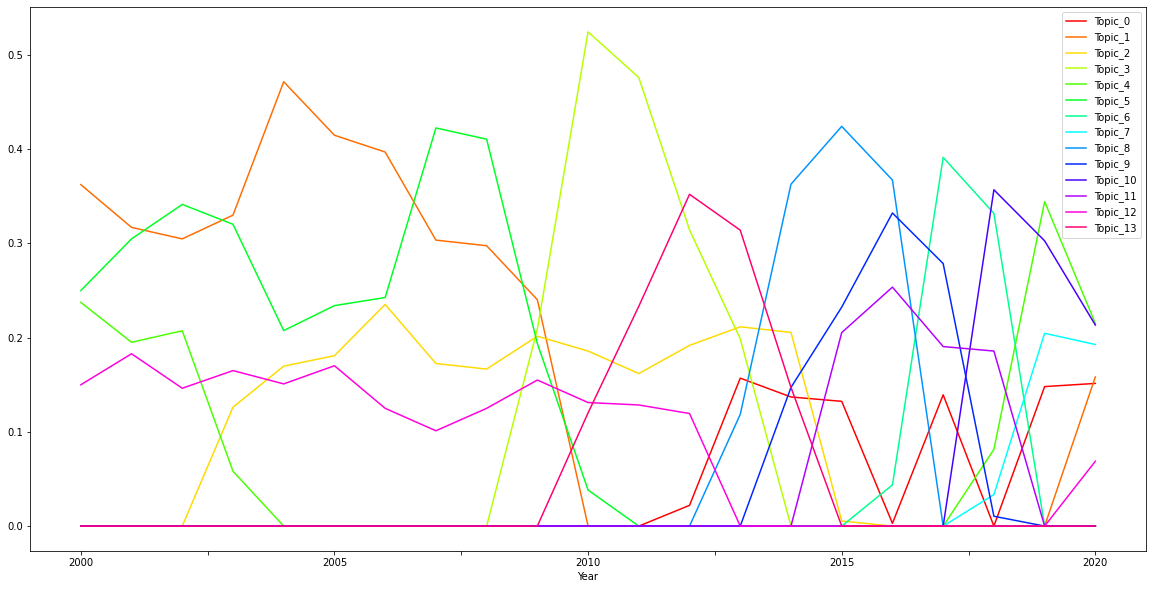

In [572]:
df_weight_dom_topics = df

for i in range(0,len(df_weight_dom_topics.index)):
    for j in range(0,14):
        if (df_weight_dom_topics.at[i, 'Dominant_Topic'] == 'Topic_' + str(j)):
            a = 0
            #df_weight_dom_topics.at[i, 'Topic_' + str(j)] = 1
        else:
            df_weight_dom_topics.at[i, 'Topic_' + str(j)] = 0


#df_weight_dom_topics = df_weight_dom_topics.groupby(['Year', 'Conf']).mean()
df_weight_dom_topics = df_weight_dom_topics.groupby(['Year']).mean()
plotGraph(df_weight_dom_topics)
df_weight_dom_topics

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13
Year,,,,,,,,,,,,,,
2000,0.0,29.0,0.0,0.0,19.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2001,0.0,26.0,0.0,0.0,16.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0
2002,0.0,25.0,0.0,0.0,17.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2003,0.0,34.0,13.0,0.0,6.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0
2004,0.0,50.0,18.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2005,0.0,39.0,17.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2006,0.0,54.0,32.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0
2007,0.0,51.0,29.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0
2008,0.0,50.0,28.0,0.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0


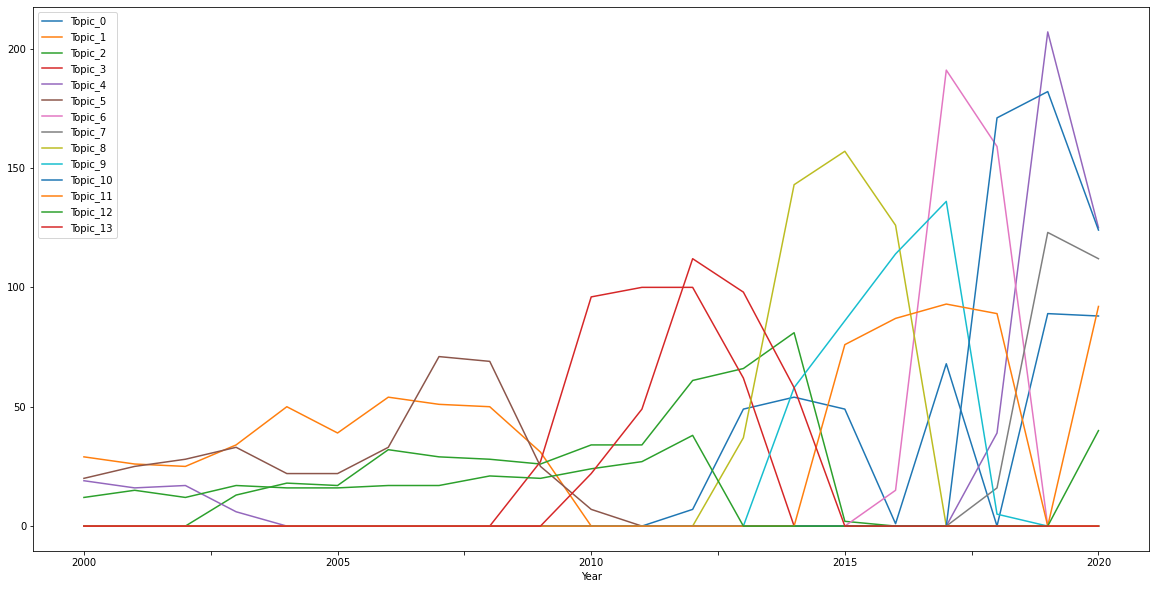

In [330]:
df_count_dom_topics = df

for i in range(0,len(df_count_dom_topics.index)):
    for j in range(0,14):
        if (df_count_dom_topics.at[i, 'Dominant_Topic'] == 'Topic_' + str(j)):
            df_count_dom_topics.at[i, 'Topic_' + str(j)] = 1
        else:
            df_count_dom_topics.at[i, 'Topic_' + str(j)] = 0


#df_count_dom_topics = df_count_dom_topics.groupby(['Year', 'Conf']).sum()
df_count_dom_topics = df_count_dom_topics.groupby(['Year']).sum()
df_count_dom_topics.plot(figsize=(20,10))
df_count_dom_topics

In [255]:
df_dominant_topic_ = df.groupby(['Year','Dominant_Topic']).count()
df_dom_top = df_dominant_topic_[['Authors']]
#df_dom_top.reset_index(drop=True, inplace=True)
df_dom_top

Authors
Year Dominant_Topic         
2000 Topic_1              29
     Topic_12             12
     Topic_4              19
     Topic_5              20
2001 Topic_1              26
...                      ...
2020 Topic_1              92
     Topic_10            124
     Topic_12             40
     Topic_4             125
     Topic_7             112

[96 rows x 1 columns]

## Plotting topic distribution over years

2000


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13
Year,,,,,,,,,,,,,,
2000,0.053168,0.071660,0.065418,0.059491,0.070031,0.094920,0.058115,0.057034,0.093303,0.057934,0.081792,0.069431,0.064685,0.103018
2001,0.053562,0.065575,0.067757,0.059402,0.070553,0.116909,0.051358,0.055252,0.099897,0.056076,0.071806,0.069897,0.063662,0.098294
2002,0.064052,0.067986,0.062915,0.071515,0.082056,0.082309,0.054574,0.059440,0.086935,0.064123,0.083240,0.067580,0.057007,0.096267
2003,0.071194,0.072862,0.058201,0.066123,0.086207,0.096315,0.053807,0.063224,0.073705,0.060193,0.088741,0.070747,0.061146,0.077534
2004,0.062626,0.073961,0.063369,0.073948,0.073083,0.080132,0.050774,0.057987,0.074273,0.079815,0.088274,0.068133,0.068488,0.085136
2005,0.073405,0.072911,0.054477,0.070112,0.076343,0.082720,0.048694,0.061799,0.083347,0.066876,0.103213,0.065681,0.062638,0.077782
2006,0.068679,0.063562,0.065032,0.072783,0.073427,0.077994,0.057106,0.064251,0.076461,0.080640,0.084984,0.067292,0.065088,0.082700
2007,0.068960,0.072417,0.064195,0.067560,0.076199,0.082035,0.061376,0.064670,0.074864,0.074124,0.075652,0.071063,0.072842,0.074043
2008,0.065736,0.071781,0.061147,0.071692,0.076654,0.074373,0.058086,0.069423,0.074536,0.069484,0.083086,0.083860,0.068072,0.072071


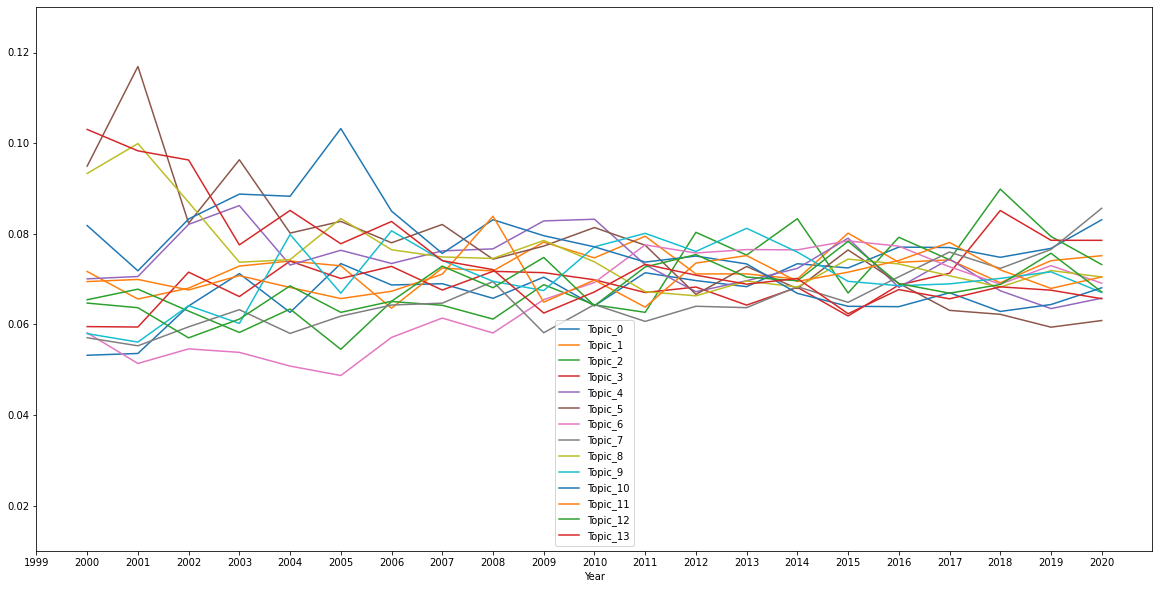

In [241]:
# Topic distribution over year graph
df_joined_year = df.groupby(['Year']).mean()
df_joined_year.pop('Dominant_Topic')
plotGraph(df_joined_year)
df_joined_year

2000


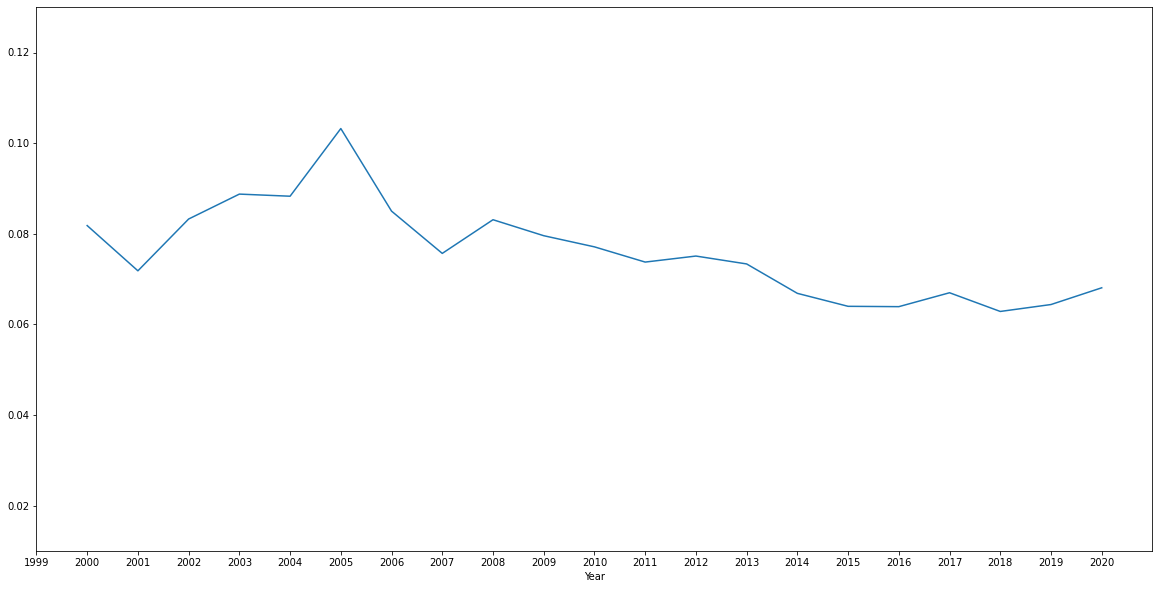

In [196]:
df_joined_year_topic10 = df_joined_year['Topic_10']
plotGraph(df_joined_year_topic10)

In [42]:
df_document_per_topic.sort_values('Perc_Documents')

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents,Year,Conf
2910,9,"network, traffic, internet, measurement, packe...",99,0.0237,2012,IEEE
497,9,"network, traffic, internet, measurement, packe...",99,0.0237,2016,Usenix
407,9,"network, traffic, internet, measurement, packe...",99,0.0237,2015,Usenix
1853,9,"network, traffic, internet, measurement, packe...",99,0.0237,2016,CSS
2756,9,"network, traffic, internet, measurement, packe...",99,0.0237,2007,IEEE
...,...,...,...,...,...,...
3584,13,"policy, property, access, language, verify, ty...",509,0.1219,2020,IEEE
2316,13,"policy, property, access, language, verify, ty...",509,0.1219,2019,CSS
2313,13,"policy, property, access, language, verify, ty...",509,0.1219,2019,CSS
2311,13,"policy, property, access, language, verify, ty...",509,0.1219,2019,CSS


### CSS graph

2000


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
Year,,,,,,,,,,,,,,,,,
2000,0.058881,0.059223,0.058508,0.058168,0.057271,0.058966,0.058545,0.058981,0.058512,0.058693,0.058253,0.059381,0.058351,0.060185,0.059153,0.059006,0.059924
2001,0.058688,0.060430,0.058851,0.057528,0.058591,0.057909,0.058499,0.058360,0.057944,0.058498,0.058211,0.059515,0.058956,0.059229,0.058684,0.059699,0.060407
2002,0.058086,0.059493,0.058960,0.058443,0.058040,0.057543,0.059463,0.058854,0.058300,0.058646,0.057261,0.059740,0.058654,0.060347,0.058547,0.059659,0.059966
2003,0.059102,0.059930,0.057746,0.058389,0.059111,0.057719,0.059521,0.058313,0.058200,0.058517,0.057522,0.059943,0.058669,0.059908,0.059028,0.059411,0.058970
2004,0.058264,0.059046,0.058757,0.057837,0.058363,0.057678,0.059748,0.058908,0.057726,0.058354,0.058188,0.059862,0.058566,0.061281,0.058491,0.058694,0.060237
2005,0.059429,0.059211,0.058124,0.058149,0.058683,0.057631,0.058967,0.059358,0.058405,0.057774,0.057804,0.059649,0.058252,0.060767,0.058635,0.059436,0.059726
2006,0.058868,0.059155,0.058471,0.058421,0.058151,0.057979,0.058796,0.058494,0.057976,0.059134,0.058000,0.059723,0.059009,0.059599,0.059694,0.058986,0.059541
2007,0.059035,0.060019,0.058497,0.057438,0.058348,0.057164,0.059200,0.058948,0.057719,0.058504,0.058002,0.059651,0.058324,0.060470,0.059413,0.059427,0.059839
2008,0.059225,0.059440,0.058313,0.057542,0.058726,0.057907,0.059420,0.059173,0.057934,0.058083,0.058255,0.059129,0.058338,0.060350,0.058562,0.059638,0.059967


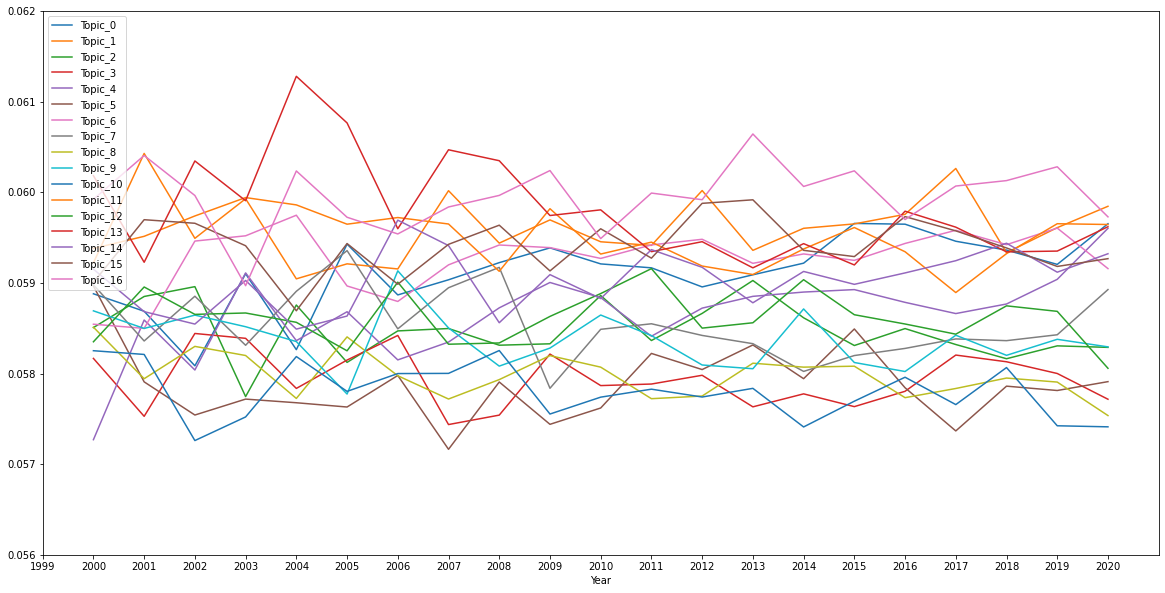

In [104]:
# Topic distribution over year graph for CSS
df_css = df[df['Conf'] == 'CSS'].groupby(['Year']).mean()
plotGraph(df_css)
df_css

### IEEE graph

2000


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
Year,,,,,,,,,,,,,,,,,
2000,0.058362,0.058738,0.058858,0.059212,0.058439,0.059044,0.059469,0.059181,0.058515,0.058242,0.058098,0.057946,0.058124,0.060268,0.059000,0.059313,0.059191
2001,0.059277,0.058894,0.058498,0.059446,0.059081,0.059146,0.059711,0.058479,0.059938,0.057263,0.057938,0.057712,0.058930,0.059264,0.058730,0.057540,0.060153
2002,0.058965,0.058001,0.058531,0.059628,0.059085,0.059365,0.058891,0.058575,0.058322,0.057635,0.058667,0.058310,0.059497,0.059392,0.059549,0.058445,0.059142
2003,0.059472,0.059217,0.058026,0.058825,0.058802,0.059408,0.060282,0.058152,0.058093,0.057877,0.058505,0.057106,0.058755,0.059831,0.059736,0.058492,0.059422
2004,0.059378,0.058014,0.058715,0.059671,0.058371,0.060422,0.059217,0.058205,0.058896,0.057582,0.057868,0.057419,0.059561,0.059795,0.059429,0.057878,0.059581
2005,0.058178,0.060668,0.059912,0.058707,0.058125,0.058666,0.059187,0.057160,0.059889,0.056993,0.058998,0.057639,0.060396,0.059702,0.059258,0.057593,0.058930
2006,0.058431,0.059142,0.058855,0.059134,0.058847,0.059153,0.058885,0.059562,0.058421,0.057238,0.058813,0.058381,0.059084,0.058837,0.059139,0.058323,0.059754
2007,0.058068,0.059244,0.058154,0.059259,0.058576,0.059237,0.059553,0.057944,0.059117,0.058252,0.058381,0.058779,0.058914,0.059169,0.059172,0.058297,0.059885
2008,0.059042,0.059204,0.059299,0.058886,0.058759,0.058466,0.059140,0.058301,0.058851,0.057287,0.059232,0.057531,0.058928,0.060559,0.059372,0.057933,0.059208


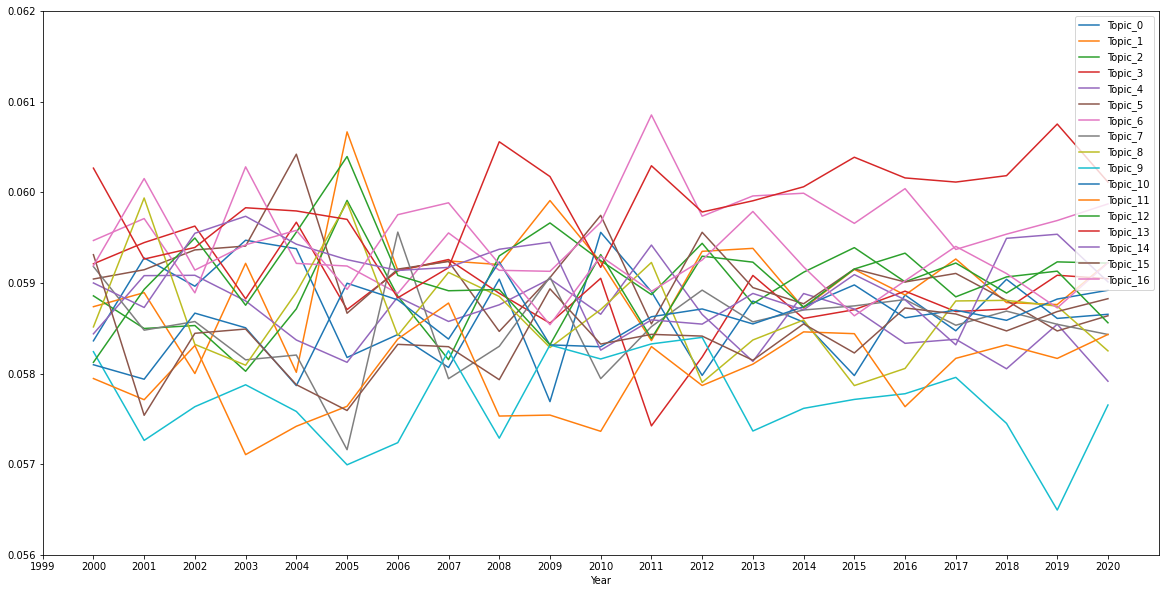

In [45]:
# Topic distribution over year graph for IEEE
df_ieee = df[df['Conf'] == 'IEEE'].groupby(['Year']).mean()
plotGraph(df_ieee)
df_ieee

### USENIX graph

2012


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
Year,,,,,,,,,,,,,,,,,
2012,0.059461,0.059086,0.058865,0.059161,0.058338,0.058893,0.059086,0.058771,0.058752,0.058247,0.058652,0.057783,0.059261,0.059915,0.058529,0.058525,0.058674
2013,0.059070,0.058815,0.058352,0.059276,0.058412,0.058551,0.059210,0.058697,0.059049,0.057945,0.058724,0.058098,0.059789,0.059750,0.058870,0.058435,0.058957
2014,0.059571,0.058955,0.058275,0.059253,0.058798,0.058777,0.059436,0.058436,0.058927,0.058306,0.058417,0.058266,0.059049,0.059652,0.058751,0.058663,0.058468
2015,0.059445,0.059162,0.057827,0.059112,0.058376,0.058389,0.059416,0.058650,0.060089,0.057861,0.058741,0.057717,0.059497,0.059201,0.058701,0.058768,0.059050
2016,0.059455,0.059643,0.057832,0.059124,0.058645,0.058387,0.059508,0.058367,0.059486,0.057844,0.058048,0.058040,0.059408,0.059494,0.058931,0.059200,0.058587
2017,0.059423,0.059122,0.058518,0.059375,0.058454,0.058800,0.059209,0.058833,0.059400,0.057515,0.057949,0.057860,0.059841,0.059889,0.058612,0.058769,0.058432
2018,0.059115,0.059305,0.058664,0.059212,0.058664,0.058966,0.059102,0.058332,0.059001,0.057857,0.058299,0.057961,0.059277,0.059719,0.058769,0.058967,0.058792
2019,0.059587,0.059250,0.058662,0.058977,0.058812,0.058181,0.059408,0.058336,0.059284,0.057348,0.058022,0.058100,0.059316,0.060276,0.058808,0.058894,0.058739
2020,0.059192,0.059016,0.058626,0.059192,0.058743,0.058782,0.058694,0.058433,0.059829,0.057700,0.058003,0.057661,0.059477,0.059806,0.058833,0.058991,0.059020


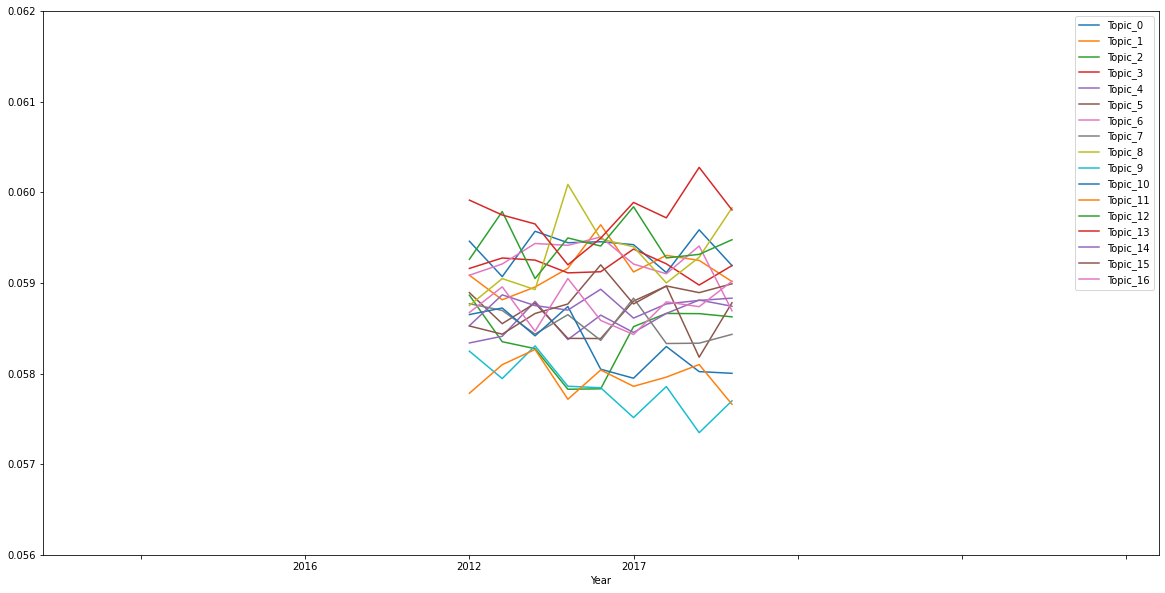

In [118]:
# Topic distribution over year graph for USENIX
df_usenix = df[df['Conf'] == 'Usenix'].groupby(['Year']).mean()
plotGraph(df_usenix)
df_usenix

### NDSS graph

2012


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
Year,,,,,,,,,,,,,,,,,
2012,0.058988,0.058910,0.058703,0.059077,0.058616,0.058735,0.058996,0.058560,0.059044,0.058400,0.058797,0.058717,0.058941,0.059141,0.058973,0.058610,0.058792
2013,0.059125,0.059286,0.058651,0.059037,0.058674,0.058587,0.058669,0.058519,0.058797,0.058495,0.058770,0.058474,0.059018,0.059362,0.058709,0.058704,0.059121
2014,0.059001,0.058933,0.058761,0.058881,0.058827,0.058807,0.058972,0.058705,0.059137,0.058459,0.058710,0.058830,0.058778,0.059171,0.058544,0.058860,0.058624
2015,0.059146,0.058496,0.058269,0.059005,0.059192,0.058357,0.060224,0.058636,0.059404,0.057253,0.058088,0.057858,0.059949,0.060107,0.059261,0.058873,0.057882
2016,0.058663,0.058802,0.058680,0.059426,0.060262,0.059426,0.058831,0.059405,0.058837,0.057823,0.057569,0.058538,0.061196,0.057370,0.058212,0.057710,0.059250
2017,0.059570,0.059078,0.058535,0.059355,0.058654,0.058251,0.059475,0.058544,0.059430,0.057681,0.057933,0.057668,0.059769,0.059253,0.058772,0.058699,0.059333
2019,0.058829,0.060031,0.058539,0.059414,0.059542,0.059440,0.058573,0.058298,0.059822,0.056580,0.057619,0.057363,0.060841,0.060945,0.058368,0.058101,0.057693
2020,0.058873,0.060305,0.059427,0.060627,0.057744,0.058666,0.058687,0.058738,0.060107,0.056177,0.056344,0.057300,0.060659,0.060764,0.058024,0.059177,0.058380


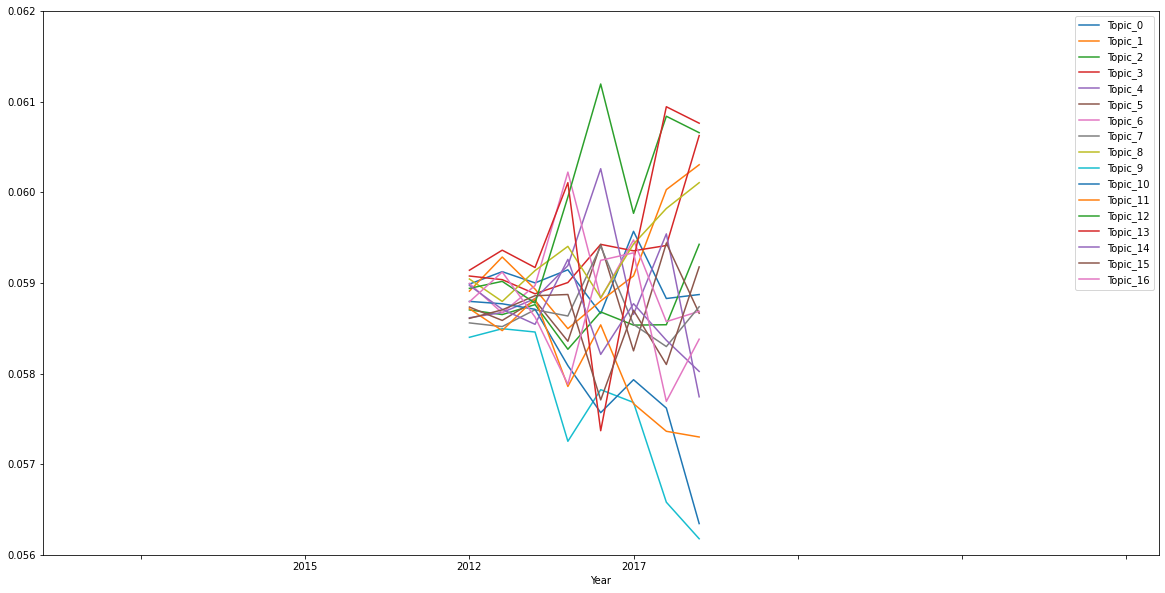

In [119]:
# Topic distribution over year graph for NDSS
df_ndss = df[df['Conf'] == 'NDSS'].groupby(['Year']).mean()
plotGraph(df_ndss)
df_ndss